# MNIST Classification using MLP
The task at hand involves creating a Multilayer Perceptron (MLP) from the ground up to perform classification on the MNIST digit dataset. This dataset encompasses various handwritten digits, and the ultimate objective is to construct a specialized model capable of accurately recognizing these handwritten digits, essentially resulting in a proficient handwritten digit recognition system.

# 1. Importing the Libraries

In [22]:
import numpy as np
import torch
import matplotlib.pylab as plt
import math

import pandas as pd
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.optim import Adam

from sklearn.metrics import confusion_matrix
import seaborn as sns
from time import time

if torch.cuda.is_available():
  device = torch.device("cude:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

CPU


# 2. Loading the Data

In [23]:
train_data = dsets.MNIST(root = './data', train = True, transform = transforms.ToTensor(), target_transform=lambda x : nn.functional.one_hot(torch.tensor([x]),10), download = True)
test_data = dsets.MNIST(root = './data', train = False, transform = transforms.ToTensor(), target_transform=lambda x : nn.functional.one_hot(torch.tensor([x]),10), download = True)

# mnist_train=torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor(), target_transform=lambda x : nn.functional.one_hot(torch.tensor([x]),10))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [24]:
image,label = train_data[0]
image.shape

torch.Size([1, 28, 28])

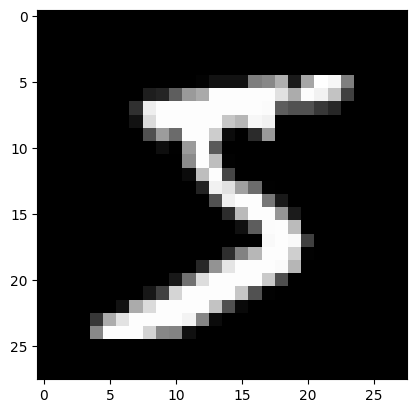

In [25]:
plt.imshow(image[0],cmap='gray')

In [26]:
# creating batches of 64
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [74]:
for i in train_loader:
  img, lbl = i
  print(lbl.shape)
  break

torch.Size([64, 1, 10])


# 3. Building the model

### Initialising the weights and biases

In [28]:
#glorot initialisation
def glorot(n_o,n_i):
  M = math.sqrt(6/(n_i+n_o))
  return M

In [29]:
# defining global variables
W=[torch.Tensor(500,784),torch.Tensor(250, 500),torch.Tensor(100, 250),torch.Tensor(10, 100)]
b=[torch.Tensor(500,1),torch.Tensor(250,1),torch.Tensor(100,1),torch.Tensor(10,1)]

In [30]:
#initialising weights ad biases
def initialise():
  M1 = glorot(500,784)
  W1 = torch.rand(500, 784) * (2 * M1) - M1
  b1 = torch.zeros((500,1))
  M2 = glorot(250,500)
  W2 = torch.rand(250, 500) * (2 * M2) - M2
  b2 = torch.zeros((250,1))
  M3 = glorot(100,250)
  W3 = torch.rand(100, 250) * (2 * M3) - M3
  b3 = torch.zeros((100,1))
  M4 = glorot(10,100)
  W4 = torch.rand(10, 100) * (2 * M4) - M4
  b4 = torch.zeros((10,1))
  W = [W1,W2,W3,W4]
  b = [b1,b2,b3,b4]
  return W,b

### Defining the functions needed for the model

In [78]:
#defining activation functions
def sigmoid(Z):
  A = 1 / (1 + np.exp(-Z))
  return A

def relu(Z):
  A = np.maximum(0,Z)
  return A

def tanh(Z):
  return torch.tanh(Z)

def softmax(Z):
  A = np.exp(Z) / np.exp(Z).sum().item()
  return A

In [32]:
relu(torch.tensor([1,2,-3,4]))

tensor([1, 2, 0, 4])

In [33]:
#defining derivations of activation functions
def sigmoid_derivative(Z):
  return (sigmoid(Z)*(1-sigmoid(Z)))

def relu_derivative(Z):
  num=torch.max(abs(Z)/Z,torch.tensor(0))
  return num

def tanh_derivative(Z):
  return (1-(tanh(Z))**2)

In [34]:
relu_derivative(torch.tensor([1,2,-3,4]))

tensor([1., 1., 0., 1.])

In [35]:
#defining the loss function
def cross_entropy_loss(y_pred, y_actual):
  loss=-1*torch.log(y_pred)*y_actual
  return torch.max(loss)

In [36]:
#defining the forward pass
def forward_pass_sigmoid(X, W, b):
  z1 = X
  a1 = X
  z2 = torch.matmul(W[0], X) + b[0]
  a2 = sigmoid(z2)
  z3 = torch.matmul(W[1], a2) + b[1]
  a3 = sigmoid(z3)
  z4 = torch.matmul(W[2], a3) + b[2]
  a4 = sigmoid(z4)
  z5 = torch.matmul(W[3], a4) + b[3]
  a5 = softmax(z5)
  return [z1,z2,z3,z4,z5],[a1,a2,a3,a4,a5]

In [37]:
#defining the forward pass for tanh
def forward_pass_tanh(X, W, b):
  z1 = X
  a1 = X
  z2 = torch.matmul(W[0], X) + b[0]
  a2 = tanh(z2)
  z3 = torch.matmul(W[1], a2) + b[1]
  a3 = tanh(z3)
  z4 = torch.matmul(W[2], a3) + b[2]
  a4 = tanh(z4)
  z5 = torch.matmul(W[3], a4) + b[3]
  a5 = softmax(z5)
  return [z1,z2,z3,z4,z5],[a1,a2,a3,a4,a5]

In [38]:
#defining the forward pass for relu
def forward_pass_relu(X, W, b):
  z1 = X
  a1 = X
  z2 = torch.matmul(W[0], X) + b[0]
  a2 = relu(z2)
  z3 = torch.matmul(W[1], a2) + b[1]
  a3 = relu(z3)
  z4 = torch.matmul(W[2], a3) + b[2]
  a4 = relu(z4)
  z5 = torch.matmul(W[3], a4) + b[3]
  a5 = softmax(z5)
  return [z1,z2,z3,z4,z5],[a1,a2,a3,a4,a5]

In [39]:
# defining backpropogation for sigmoid activation
def back_prop_sigmoid(W,b,z,a,y_actual):
  dj_dw = [torch.Tensor(500,784),torch.Tensor(250, 500),torch.Tensor(100, 250),torch.Tensor(10, 100)]
  dj_db = [torch.Tensor(500,1),torch.Tensor(250,1),torch.Tensor(100,1),torch.Tensor(10,1)]
  del5 = a[4]-torch.transpose(y_actual,0,1)

  dj_dw[3] = torch.matmul(del5,torch.transpose(a[3],0,1))
  dj_db[3] = del5
  deltemp = del5
  for i in range (3,0,-1):
    deli = torch.matmul(torch.transpose(W[i],0,1),deltemp)*sigmoid_derivative(z[i])
    deltemp = deli
    dj_dw[i-1] = torch.matmul(deli,torch.transpose(a[i-1],0,1))
    dj_db[i-1] = deli

  return dj_dw,dj_db

In [40]:
# defining backpropogation for tanh activation
def back_prop_tanh(W,b,z,a,y_actual):
  dj_dw = [torch.Tensor(500,784),torch.Tensor(250, 500),torch.Tensor(100, 250),torch.Tensor(10, 100)]
  dj_db = [torch.Tensor(500,1),torch.Tensor(250,1),torch.Tensor(100,1),torch.Tensor(10,1)]
  del5 = a[4]-torch.transpose(y_actual,0,1)

  dj_dw[3] = torch.matmul(del5,torch.transpose(a[3],0,1))
  dj_db[3] = del5
  deltemp = del5
  for i in range (3,0,-1):
    deli = torch.matmul(torch.transpose(W[i],0,1),deltemp)*tanh_derivative(z[i])
    deltemp = deli
    dj_dw[i-1] = torch.matmul(deli,torch.transpose(a[i-1],0,1))
    dj_db[i-1] = deli

  return dj_dw,dj_db

In [41]:
# defining backpropogation for relu activation
def back_prop_relu(W,b,z,a,y_actual):
  dj_dw = [torch.Tensor(500,784),torch.Tensor(250, 500),torch.Tensor(100, 250),torch.Tensor(10, 100)]
  dj_db = [torch.Tensor(500,1),torch.Tensor(250,1),torch.Tensor(100,1),torch.Tensor(10,1)]
  del5 = a[4]-torch.transpose(y_actual,0,1)

  dj_dw[3] = torch.matmul(del5,torch.transpose(a[3],0,1))
  dj_db[3] = del5
  deltemp = del5
  for i in range (3,0,-1):
    deli = torch.matmul(torch.transpose(W[i],0,1),deltemp)*relu_derivative(z[i])
    deltemp = deli
    dj_dw[i-1] = torch.matmul(deli,torch.transpose(a[i-1],0,1))
    dj_db[i-1] = deli

  return dj_dw,dj_db

### Implementing the primary model with sigmoid activation function

In [43]:
epochs = 15
alpha = 0.01
iter_list=[]
loss_list=[]
iter = 0

W1,b1 = initialise()

for j in range(epochs):
  print("Epoch = ",j)
  for batch in train_loader:
    iter = iter+1
    loss=0
    image,label = batch

    dj_dw1 = 0
    dj_db1 = 0
    dj_dw2 = 0
    dj_db2 = 0
    dj_dw3 = 0
    dj_db3 = 0
    dj_dw4 = 0
    dj_db4 = 0

    for i in range(image.shape[0]):
      z,a = forward_pass_sigmoid(torch.unsqueeze(torch.flatten(image[i]),1), W1,b1)
      dj_dw,dj_db = back_prop_sigmoid(W1,b1,z,a,label[i])

      dj_dw1 += dj_dw[0]
      dj_db1 += dj_db[0]
      dj_dw2 += dj_dw[1]
      dj_db2 += dj_db[1]
      dj_dw3 += dj_dw[2]
      dj_db3 += dj_db[2]
      dj_dw4 += dj_dw[3]
      dj_db4 += dj_db[3]
      loss+=(cross_entropy_loss(a[4],torch.transpose(label[i],0,1)))/image.shape[0]

    W1[0] -= alpha*dj_dw1/image.shape[0]
    b1[0] -= alpha*dj_db1/image.shape[0]
    W1[1] -= alpha*dj_dw2/image.shape[0]
    b1[1] -= alpha*dj_db2/image.shape[0]
    W1[2] -= alpha*dj_dw3/image.shape[0]
    b1[2] -= alpha*dj_db3/image.shape[0]
    W1[3] -= alpha*dj_dw4/image.shape[0]
    b1[3] -= alpha*dj_db4/image.shape[0]

    if (iter%200 == 0 or iter%938 == 0):
      iter_list.append(iter)
      print("Iteration = ",iter)
      loss_list.append(loss)
      print("Loss = ",loss)

Epoch =  0
Iteration =  200
Loss =  tensor(2.3055)
Iteration =  400
Loss =  tensor(2.3024)
Iteration =  600
Loss =  tensor(2.2857)
Iteration =  800
Loss =  tensor(2.2767)
Iteration =  938
Loss =  tensor(2.2897)
Epoch =  1
Iteration =  1000
Loss =  tensor(2.2988)
Iteration =  1200
Loss =  tensor(2.2917)
Iteration =  1400
Loss =  tensor(2.2839)
Iteration =  1600
Loss =  tensor(2.2850)
Iteration =  1800
Loss =  tensor(2.2736)
Iteration =  1876
Loss =  tensor(2.2685)
Epoch =  2
Iteration =  2000
Loss =  tensor(2.2809)
Iteration =  2200
Loss =  tensor(2.2691)
Iteration =  2400
Loss =  tensor(2.2626)
Iteration =  2600
Loss =  tensor(2.2656)
Iteration =  2800
Loss =  tensor(2.2402)
Iteration =  2814
Loss =  tensor(2.2294)
Epoch =  3
Iteration =  3000
Loss =  tensor(2.2495)
Iteration =  3200
Loss =  tensor(2.2424)
Iteration =  3400
Loss =  tensor(2.2133)
Iteration =  3600
Loss =  tensor(2.2222)
Iteration =  3752
Loss =  tensor(2.2270)
Epoch =  4
Iteration =  3800
Loss =  tensor(2.2226)
Iterati

Text(0.5, 1.0, 'Loss vs Iterations')

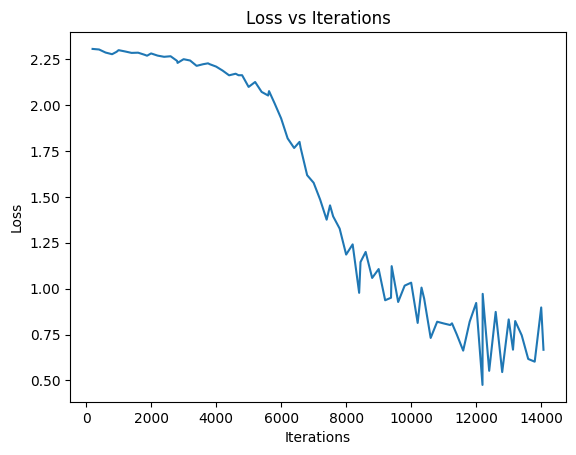

In [44]:
#plotting the loss vs iterations
plt.plot(iter_list,loss_list)

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations')

In [45]:
#finding the training accuracy
tra_iter=0
tr_iter=[]
tr_loss=[]
count = 0
for batch in train_loader:
  image, label = batch
  for i in range(image.shape[0]):
    z,a = forward_pass_sigmoid(torch.unsqueeze(torch.flatten(image[i]),1), W1,b1)
    loss+=(cross_entropy_loss(a[4],torch.transpose(label[i],0,1)))/image.shape[0]
    tra_iter+=1
    if(torch.argmax(label[i]) == torch.argmax(a[4])):
      count+=1

#finding the accuracy of the model on the test data
accuracy = (count/60000)*100
print("Training accuracy of the Model = ",accuracy)

Training accuracy of the Model =  81.99333333333333


Test accuracy of the Model =  82.5


<AxesSubplot:>

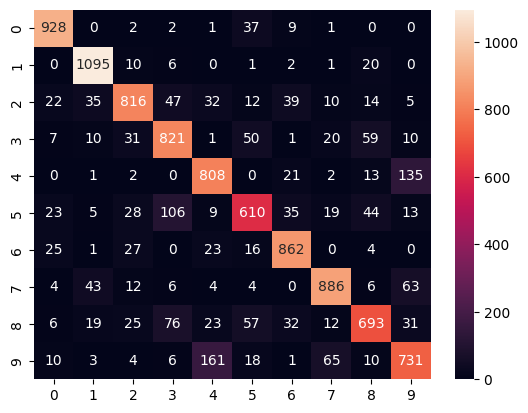

In [46]:
#finding the test accuracy and plotting the confusion matrix
y_pred=[]
y_truth=[]
tes_iter=0
test_iter=[]
test_loss=[]
count = 0
for batch in test_loader:
  image, label = batch
  for i in range(image.shape[0]):
    z,a = forward_pass_sigmoid(torch.unsqueeze(torch.flatten(image[i]),1), W1,b1)
    loss+=(cross_entropy_loss(a[4],torch.transpose(label[i],0,1)))/image.shape[0]
    tes_iter+=1
    y_pred.append(torch.argmax(a[4]))
    y_truth.append(torch.argmax(label[i]))
    if(torch.argmax(label[i]) == torch.argmax(a[4])):
      count+=1
    if(tes_iter%200==0):
      test_loss.append(loss)
      test_iter.append(tes_iter)

#finding the accuracy of the model on the test data
accuracy = (count/10000)*100
print("Test accuracy of the Model = ",accuracy)

#plotting the confusion matrix
cm=confusion_matrix(y_truth,y_pred)
sns.heatmap(cm,annot=True,fmt='d')

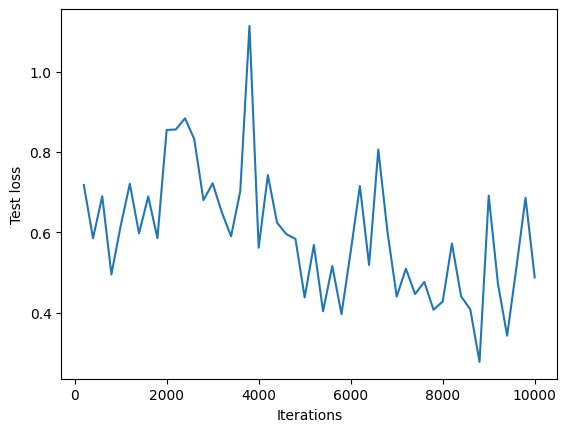

In [47]:
#plotting the test loss vs iterations
# plt.plot(test_iter,test_loss)
# plt.xlabel("Iterations")
# plt.ylabel("Test Loss")
# plt.title('Test Loss vs Iterations')
# plt.show()

#plotting the test loss vs iterations
tes_iter=0
count=0
test_iter=[]
test_loss=[]
for batch in test_loader:
  image, label = batch

  loss=0
  for i in range(0,image.shape[0]):
    z,a = forward_pass_sigmoid(torch.unsqueeze(torch.flatten(image[i]),1), W1,b1)
    loss+=(cross_entropy_loss(a[4],torch.transpose(label[i],0,1)))/image.shape[0]
    tes_iter+=1
    if(torch.argmax(label[i]) == torch.argmax(a[4])):
      count+=1
    if(tes_iter%200==0):
      test_loss.append(loss)
      test_iter.append(tes_iter)

plt.plot(test_iter,test_loss)
plt.xlabel("Iterations")
plt.ylabel("Test loss")
plt.show()

### Implementing the model with tanh instead of sigmoid

In [48]:
epochs = 15
alpha = 0.01
iter_list=[]
loss_list=[]
iter = 0

W2,b2 = initialise()

for j in range(epochs):
  print("Epoch = ",j)
  for batch in train_loader:
    iter = iter+1
    loss=0
    image,label = batch

    dj_dw1 = 0
    dj_db1 = 0
    dj_dw2 = 0
    dj_db2 = 0
    dj_dw3 = 0
    dj_db3 = 0
    dj_dw4 = 0
    dj_db4 = 0

    for i in range(image.shape[0]):
      z,a = forward_pass_tanh(torch.unsqueeze(torch.flatten(image[i]),1), W2,b2)
      dj_dw,dj_db = back_prop_tanh(W2,b2,z,a,label[i])

      dj_dw1 += dj_dw[0]
      dj_db1 += dj_db[0]
      dj_dw2 += dj_dw[1]
      dj_db2 += dj_db[1]
      dj_dw3 += dj_dw[2]
      dj_db3 += dj_db[2]
      dj_dw4 += dj_dw[3]
      dj_db4 += dj_db[3]
      loss+=(cross_entropy_loss(a[4],torch.transpose(label[i],0,1)))/image.shape[0]

    W2[0] -= alpha*dj_dw1/image.shape[0]
    b2[0] -= alpha*dj_db1/image.shape[0]
    W2[1] -= alpha*dj_dw2/image.shape[0]
    b2[1] -= alpha*dj_db2/image.shape[0]
    W2[2] -= alpha*dj_dw3/image.shape[0]
    b2[2] -= alpha*dj_db3/image.shape[0]
    W2[3] -= alpha*dj_dw4/image.shape[0]
    b2[3] -= alpha*dj_db4/image.shape[0]

    if (iter%200 == 0 or iter%938 == 0):
      iter_list.append(iter)
      print("Iteration = ",iter)
      loss_list.append(loss)
      print("Loss = ",loss)

Epoch =  0
Iteration =  200
Loss =  tensor(0.7687)
Iteration =  400
Loss =  tensor(0.7651)
Iteration =  600
Loss =  tensor(0.5002)
Iteration =  800
Loss =  tensor(0.4249)
Iteration =  938
Loss =  tensor(0.4477)
Epoch =  1
Iteration =  1000
Loss =  tensor(0.3836)
Iteration =  1200
Loss =  tensor(0.3734)
Iteration =  1400
Loss =  tensor(0.4152)
Iteration =  1600
Loss =  tensor(0.2695)
Iteration =  1800
Loss =  tensor(0.2797)
Iteration =  1876
Loss =  tensor(0.3990)
Epoch =  2
Iteration =  2000
Loss =  tensor(0.3511)
Iteration =  2200
Loss =  tensor(0.3510)
Iteration =  2400
Loss =  tensor(0.2890)
Iteration =  2600
Loss =  tensor(0.1707)
Iteration =  2800
Loss =  tensor(0.3964)
Iteration =  2814
Loss =  tensor(0.2651)
Epoch =  3
Iteration =  3000
Loss =  tensor(0.1888)
Iteration =  3200
Loss =  tensor(0.2549)
Iteration =  3400
Loss =  tensor(0.2111)
Iteration =  3600
Loss =  tensor(0.2449)
Iteration =  3752
Loss =  tensor(0.1738)
Epoch =  4
Iteration =  3800
Loss =  tensor(0.2270)
Iterati

Text(0.5, 1.0, 'Loss vs Iterations')

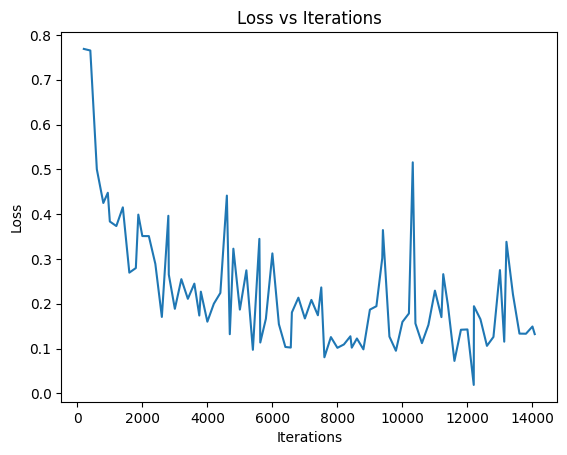

In [49]:
#plotting the loss vs iterations
plt.plot(iter_list,loss_list)

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations')

In [50]:
#finding the training accuracy
tra_iter=0
tr_iter=[]
tr_loss=[]
count = 0
for batch in train_loader:
  image, label = batch
  for i in range(image.shape[0]):
    z,a = forward_pass_tanh(torch.unsqueeze(torch.flatten(image[i]),1), W2,b2)
    loss+=(cross_entropy_loss(a[4],torch.transpose(label[i],0,1)))/image.shape[0]
    tra_iter = tra_iter + 1
    y_pred.append(torch.argmax(a[4]))
    y_truth.append(torch.argmax(label[i]))
    if(torch.argmax(label[i]) == torch.argmax(a[4])):
      count+=1

accuracy = (count/60000)*100
print("Training Accuracy of the Model = ",accuracy)

Training Accuracy of the Model =  96.53


Test Accuracy of the Model =  95.91


<AxesSubplot:>

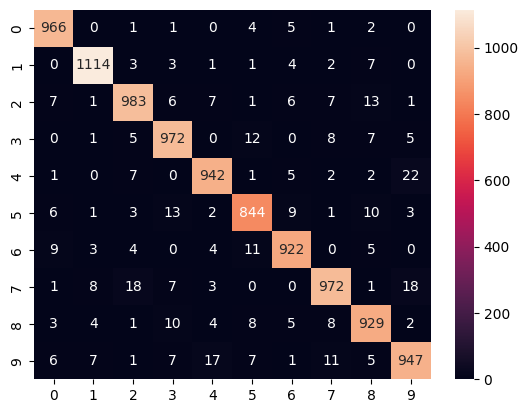

In [51]:
#finding the test accuracy and plotting the confusion matrix
y_pred=[]
y_truth=[]
tes_iter=0
test_iter=[]
test_loss=[]
count = 0
for batch in test_loader:
  image, label = batch
  for i in range(image.shape[0]):
    z,a = forward_pass_tanh(torch.unsqueeze(torch.flatten(image[i]),1), W2,b2)
    loss+=(cross_entropy_loss(a[4],torch.transpose(label[i],0,1)))/image.shape[0]
    tes_iter+=1
    y_pred.append(torch.argmax(a[4]))
    y_truth.append(torch.argmax(label[i]))
    if(torch.argmax(label[i]) == torch.argmax(a[4])):
      count+=1
    if(tes_iter%200==0):
      test_loss.append(loss)
      test_iter.append(tes_iter)

#finding the accuracy of the model on the test data
accuracy = (count/10000)*100
print("Test Accuracy of the Model = ",accuracy)

#plotting the confusion matrix
cm=confusion_matrix(y_truth,y_pred)
sns.heatmap(cm,annot=True,fmt='d')

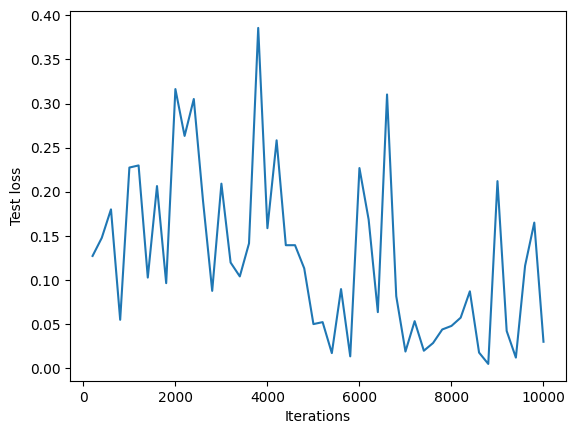

In [52]:
#plotting the test loss vs iterations
tes_iter=0
count=0
test_iter=[]
test_loss=[]
for batch in test_loader:
  image, label = batch

  loss=0
  for i in range(0,image.shape[0]):
    z,a = forward_pass_tanh(torch.unsqueeze(torch.flatten(image[i]),1), W2,b2)
    loss+=(cross_entropy_loss(a[4],torch.transpose(label[i],0,1)))/image.shape[0]
    tes_iter+=1
    if(torch.argmax(label[i]) == torch.argmax(a[4])):
      count+=1
    if(tes_iter%200==0):
      test_loss.append(loss)
      test_iter.append(tes_iter)

plt.plot(test_iter,test_loss)
plt.xlabel("Iterations")
plt.ylabel("Test loss")
plt.show()

### Implementing the model with ReLU instead of sigmoid

In [80]:
epochs = 15
alpha = 0.01
iter_list=[]
loss_list=[]
iter = 0

W3,b3 = initialise()

for j in range(epochs):
  print("Epoch = ",j)
  for batch in train_loader:
    iter = iter+1
    loss=0
    image,label = batch

    dj_dw1 = 0
    dj_db1 = 0
    dj_dw2 = 0
    dj_db2 = 0
    dj_dw3 = 0
    dj_db3 = 0
    dj_dw4 = 0
    dj_db4 = 0

    for i in range(image.shape[0]):
      z,a = forward_pass_relu(torch.unsqueeze(torch.flatten(image[i]),1), W3,b3)
      dj_dw,dj_db = back_prop_relu(W3,b3,z,a,label[i])

      dj_dw1 += dj_dw[0]
      dj_db1 += dj_db[0]
      dj_dw2 += dj_dw[1]
      dj_db2 += dj_db[1]
      dj_dw3 += dj_dw[2]
      dj_db3 += dj_db[2]
      dj_dw4 += dj_dw[3]
      dj_db4 += dj_db[3]
      loss+=(cross_entropy_loss(a[4],torch.transpose(label[i],0,1)))/image.shape[0]

    W3[0] -= alpha*dj_dw1/image.shape[0]
    b3[0] -= alpha*dj_db1/image.shape[0]
    W3[1] -= alpha*dj_dw2/image.shape[0]
    b3[1] -= alpha*dj_db2/image.shape[0]
    W3[2] -= alpha*dj_dw3/image.shape[0]
    b3[2] -= alpha*dj_db3/image.shape[0]
    W3[3] -= alpha*dj_dw4/image.shape[0]
    b3[3] -= alpha*dj_db4/image.shape[0]

    if (iter%200 == 0 or iter%938 == 0):
      iter_list.append(iter)
      print("Iteration = ",iter)
      loss_list.append(loss)
      print("Loss = ",loss)

Epoch =  0
Iteration =  200
Loss =  tensor(1.2522)
Iteration =  400
Loss =  tensor(0.5185)
Iteration =  600
Loss =  tensor(0.5834)
Iteration =  800
Loss =  tensor(0.3813)
Iteration =  938
Loss =  tensor(0.5863)
Epoch =  1
Iteration =  1000
Loss =  tensor(0.3863)
Iteration =  1200
Loss =  tensor(0.1842)
Iteration =  1400
Loss =  tensor(0.3006)
Iteration =  1600
Loss =  tensor(0.4242)
Iteration =  1800
Loss =  tensor(0.3482)
Iteration =  1876
Loss =  tensor(0.3097)
Epoch =  2
Iteration =  2000
Loss =  tensor(0.3724)
Iteration =  2200
Loss =  tensor(0.2011)
Iteration =  2400
Loss =  tensor(0.2464)
Iteration =  2600
Loss =  tensor(0.1537)
Iteration =  2800
Loss =  tensor(0.1606)
Iteration =  2814
Loss =  tensor(0.0661)
Epoch =  3
Iteration =  3000
Loss =  tensor(0.2526)
Iteration =  3200
Loss =  tensor(0.1965)
Iteration =  3400
Loss =  tensor(0.1862)
Iteration =  3600
Loss =  tensor(0.2990)
Iteration =  3752
Loss =  tensor(0.2048)
Epoch =  4
Iteration =  3800
Loss =  tensor(0.1580)
Iterati

Text(0.5, 1.0, 'Loss vs Iterations')

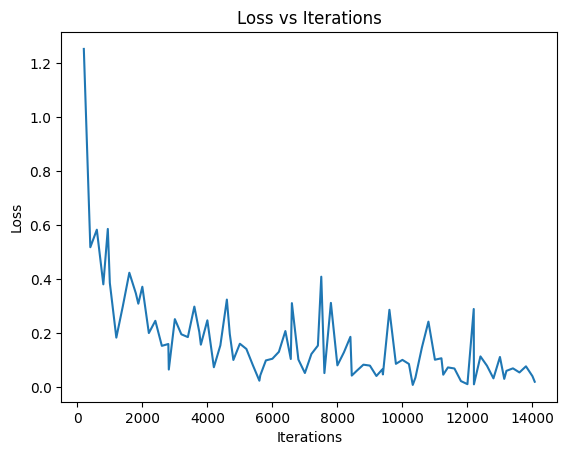

In [81]:
#plotting training loss vs iterations
plt.plot(iter_list,loss_list)

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations')

In [82]:
#finding the training accuracy
tra_iter=0
tr_iter=[]
tr_loss=[]
count = 0
for batch in train_loader:
  image, label = batch
  for i in range(image.shape[0]):
    z,a = forward_pass_relu(torch.unsqueeze(torch.flatten(image[i]),1), W3,b3)
    loss+=(cross_entropy_loss(a[4],torch.transpose(label[i],0,1)))/image.shape[0]
    tra_iter = tra_iter + 1
    y_pred.append(torch.argmax(a[4]))
    y_truth.append(torch.argmax(label[i]))
    if(torch.argmax(label[i]) == torch.argmax(a[4])):
      count+=1

accuracy = (count/60000)*100
print("Training Accuracy of the Model = ",accuracy)

Training Accuracy of the Model =  97.925


Test Accuracy of the Model =  96.97


<AxesSubplot:>

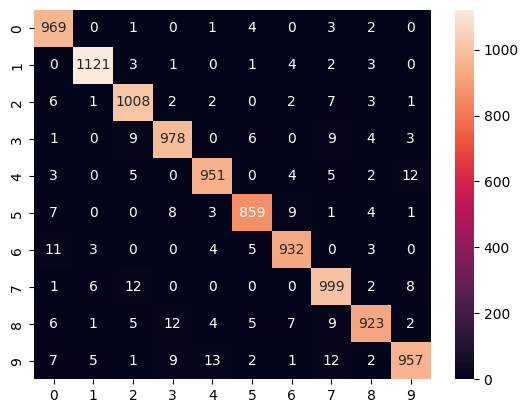

In [83]:
#finding the test accuracy and plotting the confusion matrix
y_pred=[]
y_truth=[]
tes_iter=0
test_iter=[]
test_loss=[]
count = 0
for batch in test_loader:
  image, label = batch
  for i in range(image.shape[0]):
    z,a = forward_pass_relu(torch.unsqueeze(torch.flatten(image[i]),1), W3,b3)
    loss+=(cross_entropy_loss(a[4],torch.transpose(label[i],0,1)))/image.shape[0]
    tes_iter+=1
    y_pred.append(torch.argmax(a[4]))
    y_truth.append(torch.argmax(label[i]))
    if(torch.argmax(label[i]) == torch.argmax(a[4])):
      count+=1
    if(tes_iter%200==0):
      test_loss.append(loss)
      test_iter.append(tes_iter)

#finding the accuracy of the model on the test data
accuracy = (count/10000)*100
print("Test Accuracy of the Model = ",accuracy)

#plotting the confusion matrix
cm=confusion_matrix(y_truth,y_pred)
sns.heatmap(cm,annot=True,fmt='d')

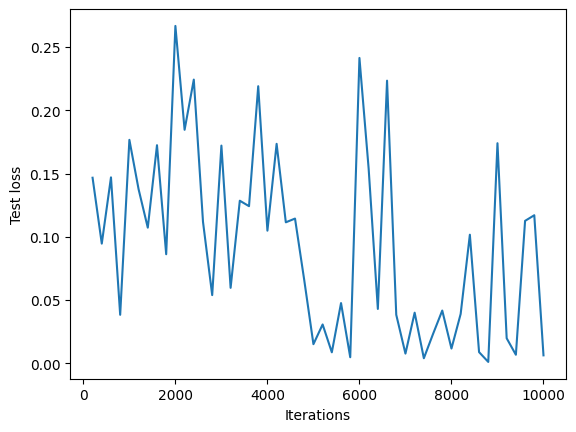

In [84]:
#plotting the test loss vs iterations
tes_iter=0
count=0
test_iter=[]
test_loss=[]
for batch in test_loader:
  image, label = batch

  loss=0
  for i in range(0,image.shape[0]):
    z,a = forward_pass_relu(torch.unsqueeze(torch.flatten(image[i]),1), W3,b3)
    loss+=(cross_entropy_loss(a[4],torch.transpose(label[i],0,1)))/image.shape[0]
    tes_iter+=1
    if(torch.argmax(label[i]) == torch.argmax(a[4])):
      count+=1
    if(tes_iter%200==0):
      test_loss.append(loss)
      test_iter.append(tes_iter)

plt.plot(test_iter,test_loss)
plt.xlabel("Iterations")
plt.ylabel("Test loss")
plt.show()

In [85]:
test_loss

[tensor(0.1467),
 tensor(0.0946),
 tensor(0.1470),
 tensor(0.0384),
 tensor(0.1766),
 tensor(0.1376),
 tensor(0.1072),
 tensor(0.1724),
 tensor(0.0862),
 tensor(0.2666),
 tensor(0.1846),
 tensor(0.2242),
 tensor(0.1118),
 tensor(0.0539),
 tensor(0.1721),
 tensor(0.0597),
 tensor(0.1285),
 tensor(0.1242),
 tensor(0.2190),
 tensor(0.1049),
 tensor(0.1735),
 tensor(0.1115),
 tensor(0.1144),
 tensor(0.0659),
 tensor(0.0152),
 tensor(0.0307),
 tensor(0.0087),
 tensor(0.0477),
 tensor(0.0048),
 tensor(0.2413),
 tensor(0.1539),
 tensor(0.0430),
 tensor(0.2234),
 tensor(0.0384),
 tensor(0.0077),
 tensor(0.0401),
 tensor(0.0041),
 tensor(0.0233),
 tensor(0.0417),
 tensor(0.0117),
 tensor(0.0391),
 tensor(0.1017),
 tensor(0.0089),
 tensor(0.0011),
 tensor(0.1740),
 tensor(0.0198),
 tensor(0.0068),
 tensor(0.1126),
 tensor(0.1171),
 tensor(0.0063)]

We can see that the ReLU model provides us with the highest accuracy, and we will hence use this to implement our pytorch model

# Building a model using pytorch

The model whihc gave us the highest accuracy was the model using the ReLU activation function so let us build a Pytorch Model with the ReLU architecture

In [86]:
#redefining the input data as we do not want it to be one hot encoded
pytorch_train=dsets.MNIST(root='./data2',train=True, download=True, transform=transforms.ToTensor())
pytorch_test=dsets.MNIST(root='./data',train=False,download=True, transform=transforms.ToTensor())
pytorchtrain_loader = torch.utils.data.DataLoader(pytorch_train, batch_size=batch_size, shuffle=True)
pytorchtest_loader = torch.utils.data.DataLoader(pytorch_test, batch_size=batch_size, shuffle=True)

In [87]:
#building the model
input_size = 784
hidden_sizes = [500, 250,100]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[2],output_size))
print(model)


criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=250, bias=True)
  (3): ReLU()
  (4): Linear(in_features=250, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=10, bias=True)
)


In [88]:
time0 = time()
epochs = 15
iterations=0
iter_val=[]
loss_val=[]
for e in range(epochs):
    running_loss = 0
    for images, labels in pytorchtrain_loader:
        iterations+=1
        # Flatten images into a 784 long vector
        images = images.view(images.shape[0], -1)

        # Training
        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)

        #backpropogation step
        loss.backward()

        #Optimizes its weights here
        optimizer.step()

        running_loss += loss.item()

        if(iterations%200==0 or iterations%938==0):
          iter_val.append(iterations)
          loss_val.append(running_loss/iterations)
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(pytorchtrain_loader)))

print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.285482466143411
Epoch 1 - Training loss: 0.17053677288811409
Epoch 2 - Training loss: 0.15059820995199433
Epoch 3 - Training loss: 0.13031339045226284
Epoch 4 - Training loss: 0.13323283365476868
Epoch 5 - Training loss: 0.11272024688398295
Epoch 6 - Training loss: 0.1104430698782582
Epoch 7 - Training loss: 0.0918985450932476
Epoch 8 - Training loss: 0.09515837556921439
Epoch 9 - Training loss: 0.08802565948501268
Epoch 10 - Training loss: 0.08379929706361296
Epoch 11 - Training loss: 0.09678851488854119
Epoch 12 - Training loss: 0.09688235213255586
Epoch 13 - Training loss: 0.07636262404207482
Epoch 14 - Training loss: 0.07812952257761176

Training Time (in minutes) = 1.2528104305267334


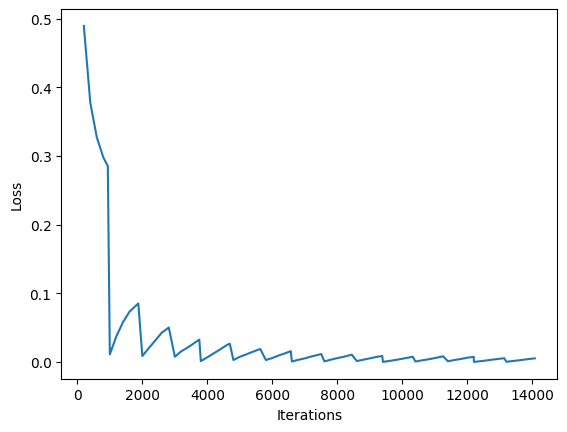

In [89]:
#plotting the training loss vs iterations
plt.plot(iter_val,loss_val)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [90]:
#training acuuracy
correct_count, all_count = 0, 0
for images,labels in pytorchtrain_loader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)


    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count)*100)

Number Of Images Tested = 60000

Model Accuracy = 98.60166666666666


In [91]:
#test accuracy
correct_count, all_count = 0, 0
for images,labels in pytorchtest_loader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)


    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count)*100)

Number Of Images Tested = 10000

Model Accuracy = 97.09


<AxesSubplot:>

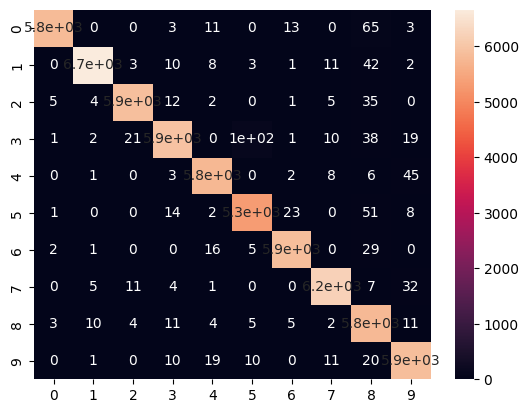

In [92]:
#for the confusion matrix
y_pred = []
y_true = []

for images, labels in pytorchtrain_loader:
        images = images.view(images.shape[0], -1)
        output = model(images)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)

        labels = labels.data.cpu().numpy()
        y_true.extend(labels)


cf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(cf_matrix, annot=True)

On comparing the Pytorch model with model from scratch we observe that the convergence to minima occurs faster in the Pytorch model due to Adam optimizer. It takes steps proportional to the rate of change of the gradient itself, making more accurate decisions. The Backpropagation done here is more accurate as it a computerized algorithm. The training error and testing error is also lesser in the Pytorch model, making it the better model

### Pytorch Model with regularisation

In [93]:
#defining the model
model_l2 = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[2],output_size))
print(model_l2)


criterion_l2 = nn.CrossEntropyLoss()
alpha=0.00001 #taking this as the value for regularization constant
optimizer_l2 = Adam(model_l2.parameters(), lr=0.01,weight_decay=alpha)

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=250, bias=True)
  (3): ReLU()
  (4): Linear(in_features=250, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=10, bias=True)
)


In [94]:
time0 = time()
epochs = 15
iterations=0
iter_val=[]
loss_val=[]
for e in range(epochs):
    running_loss = 0
    for images, labels in pytorchtrain_loader:
        iterations+=1
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        # Training pass
        optimizer_l2.zero_grad()

        output = model_l2(images)
        loss = criterion_l2(output, labels)

        #This is where the model learns by backpropagating
        loss.backward()

        #And optimizes its weights here
        optimizer_l2.step()

        running_loss += loss.item()

        if(iterations%200==0 or iterations%938==0):
          iter_val.append(iterations)
          loss_val.append(running_loss/iterations)
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(pytorchtrain_loader)))

print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.2778130959508929
Epoch 1 - Training loss: 0.1681636673038893
Epoch 2 - Training loss: 0.1448574660590161
Epoch 3 - Training loss: 0.1348801985390977
Epoch 4 - Training loss: 0.1232939567168686
Epoch 5 - Training loss: 0.1253593017557896
Epoch 6 - Training loss: 0.12401460630582524
Epoch 7 - Training loss: 0.12059389282722147
Epoch 8 - Training loss: 0.1115761388388367
Epoch 9 - Training loss: 0.11624813259694415
Epoch 10 - Training loss: 0.10240703909347
Epoch 11 - Training loss: 0.10388579921360547
Epoch 12 - Training loss: 0.1055027839361823
Epoch 13 - Training loss: 0.10137082471323983
Epoch 14 - Training loss: 0.09769772279302406

Training Time (in minutes) = 1.2499916156133015


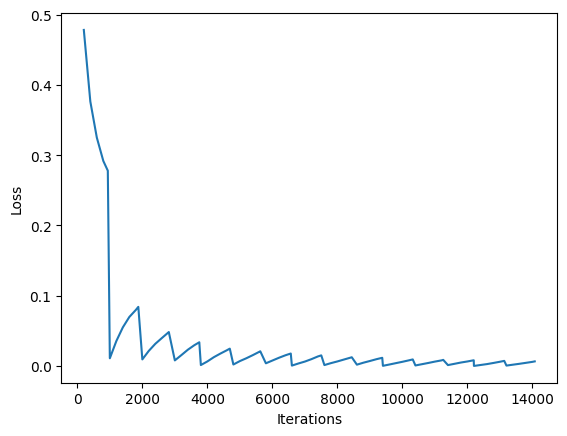

In [95]:
#plotting the training loss vs iterations
plt.plot(iter_val,loss_val)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

In [96]:
#training accuracy
correct_count, all_count = 0, 0
for images,labels in pytorchtrain_loader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model_l2(img)


    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count)*100)

Number Of Images Tested = 60000

Model Accuracy = 98.03166666666667


In [97]:
# testing accuracy
correct_count, all_count = 0, 0
for images,labels in pytorchtest_loader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model_l2(img)


    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count)*100)

Number Of Images Tested = 10000

Model Accuracy = 96.92


<AxesSubplot:>

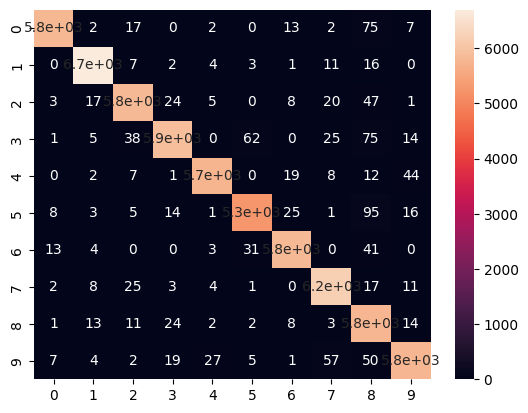

In [98]:
y_pred = []
y_true = []

# iterate over test data
for images, labels in pytorchtrain_loader:
        images = images.view(images.shape[0], -1)
        output = model_l2(images) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(cf_matrix, annot=True)

The Training accuracy of regularized model is lesser than the unregularized as expected and when the regularization parameter was kept too high (alpha>0.01) it resulted in increasing the loss. When it was kept very low (alpha<0.000001) it didnt have much effect. When alpha=0.0001, training accuracy and test accuracy became more close. This was the perfect value for alpha. When there was no regularization difference between training and test accuracy was around 1.4 %. But when regularization was used the difference in accuracy became only 0.8 %

## References
1. https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
2. https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST
3. https://youtu.be/cQMt7XqeD4M
4. https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html
5. https://pytorch.org/docs/stable/nn.init.html
6. https://discuss.pytorch.org/t/iterating-through-a-dataloader-object/25437
7. https://medium.com/@aungkyawmyint_26195/multi-layer-perceptron-mnist-pytorch-463f795b897a